In [424]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
#pd.set_option('display.max_colwidth', -1)
import numpy as np
import re

In [425]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = "whitegrid")

In [426]:
import geopandas
from shapely.geometry import LineString, Point, Polygon
import shapely.wkt
import folium

Lectura del dataset.  
Se eliminan columnas sin uso y se renombra `habitaciones_final` como `ambientes` y `total` como `superficie` 

In [427]:
df = pd.read_csv('properatti_geo.csv')
df.drop(['Unnamed: 0', 'ambientes', 'habs', 'nuevo'], axis=1, inplace=True)
df.rename(mapper={'habitaciones_final': 'ambientes', 'total': 'superficie'}, axis=1, inplace=True)
df.head(1)

,id,barrio_real,superficie,cubierta,precio,piso,expensas,descripcion,ambientes,pileta,seguridad,parrilla,balcon,cochera,geometry,dist_comisarias,dist_subte,dist_trenes,dist_metrobus
0,2,LINIERS,55.0,55.0,1309.090909,NaN,NaN,"2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AMPLIO COCINA SEPARADA CON LAVADERO, BAÑO COMPLETO Y DORMITORIO CON PLACARD. BAJAS EXPENSAS, EXCELENTE UBICACION Aviso publicado por Pixel Inmobiliario (Servicio de Páginas Web para Inmobiliarias).",2.0,0,0,0,0,0,POINT (-58.5229825 -34.6522615),2133.629728,5444.155315,1512.704661,1578.83638


Se filtra el dataset por los departamentos en Palermo y se elimina columna `barrio_real`

In [428]:
df = df[df.barrio_real == 'PALERMO']
df.drop(['barrio_real'], axis=1, inplace=True)

Se corrige el dataset original creando una nueva columna `antiguedad` que tiene 3 valores posibles: *'pozo', 'estrenar'* y *'usado'*.  
Se crea una función que toma la descripción del departamento y devuelve el valor correcto.   

In [429]:
def clasificacion(x):
    frase = x.lower()
    # matches
    if re.search(r'nuev|estre', frase): 
        return 'estrenar'
    if re.search(r'pozo', frase):
        return 'pozo'
    else:
        return 'usado'

Se aplica la función con un *apply* sobre la columna `descripcion`

In [430]:
df['antiguedad'] = df['descripcion'].apply(clasificacion)

In [431]:
df['antiguedad'].value_counts()

usado       1535
estrenar    454 
pozo        27  
Name: antiguedad, dtype: int64

Se calculan las medias para validar que el precio promedio por m2 a estrenar es el más caro y el de pozo es el más barato

In [432]:
df.precio.mean()

3289.423270353909

In [433]:
df[df.antiguedad == 'pozo']['precio'].mean()

2941.264181802489

In [434]:
df[df.antiguedad == 'usado']['precio'].mean()

3240.7024929780573

In [435]:
df[df.antiguedad == 'estrenar']['precio'].mean()

3474.856505294024

Se reflejan los valores promedio por tipo de departamento según `antiguedad`.  
Tendencia a mayor valor por m2 cuando aumenta la superficie total, que parecería darse en los barrios de mayor valor promedio de la propiedad.  

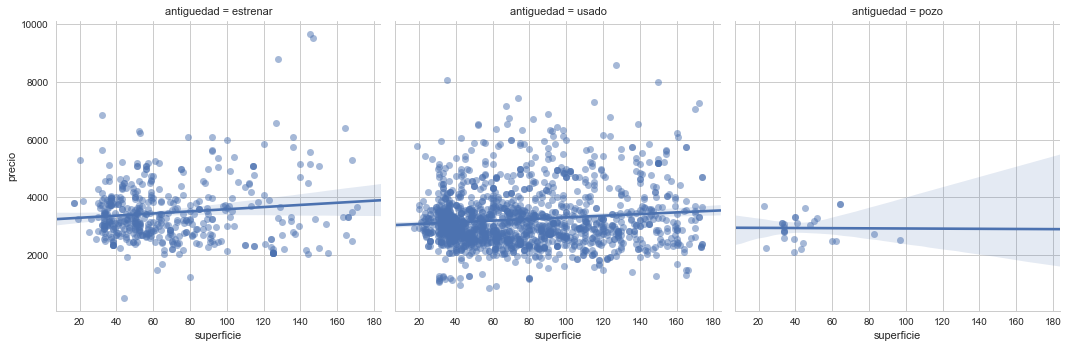

In [436]:
sns.lmplot('superficie', 'precio', data=df, col='antiguedad', col_order=['estrenar', 'usado', 'pozo'],
           fit_reg=True, scatter_kws={'alpha': 0.5});

In [437]:
df.ambientes.unique()

array([  3.,   2.,   1.,   4.,  nan,   5.,   7.,   6., 502.])

Corrección de número de ambientes para ambientes > 7 (2 casos)

In [438]:
df.shape
df.loc[df.ambientes > 7, ['id', 'ambientes']]
df = df.drop(df[df.ambientes > 10].index)
df.shape

(2016, 19)

,id,ambientes
5360,38470,502.0
6660,45931,502.0


(2014, 19)

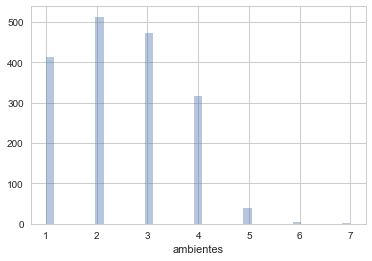

In [439]:
df1 = df.loc[df.ambientes.notnull()]
sns.distplot(df1.ambientes, kde=False);

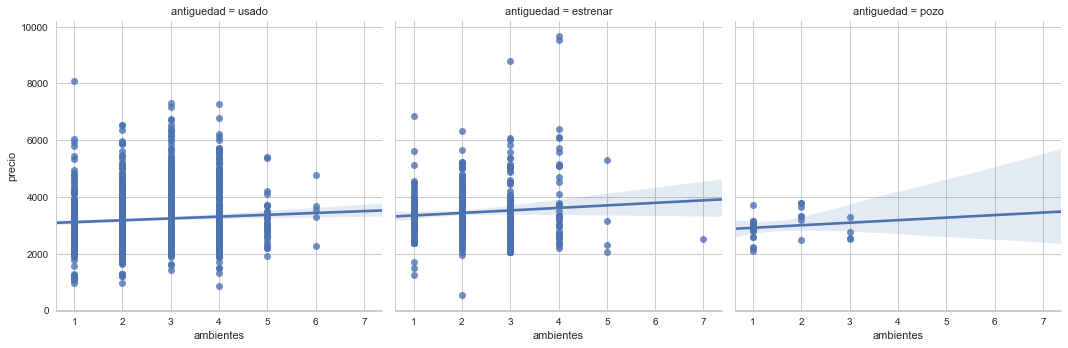

In [440]:
sns.lmplot('ambientes', 'precio', data=df1, col='antiguedad');

In [441]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1763 entries, 3 to 15913
Data columns (total 19 columns):
id                 1763 non-null int64
superficie         1763 non-null float64
cubierta           1715 non-null float64
precio             1763 non-null float64
piso               264 non-null float64
expensas           448 non-null float64
descripcion        1763 non-null object
ambientes          1763 non-null float64
pileta             1763 non-null int64
seguridad          1763 non-null int64
parrilla           1763 non-null int64
balcon             1763 non-null int64
cochera            1763 non-null int64
geometry           1763 non-null object
dist_comisarias    1763 non-null float64
dist_subte         1763 non-null float64
dist_trenes        1763 non-null float64
dist_metrobus      1763 non-null float64
antiguedad         1763 non-null object
dtypes: float64(10), int64(6), object(3)
memory usage: 275.5+ KB


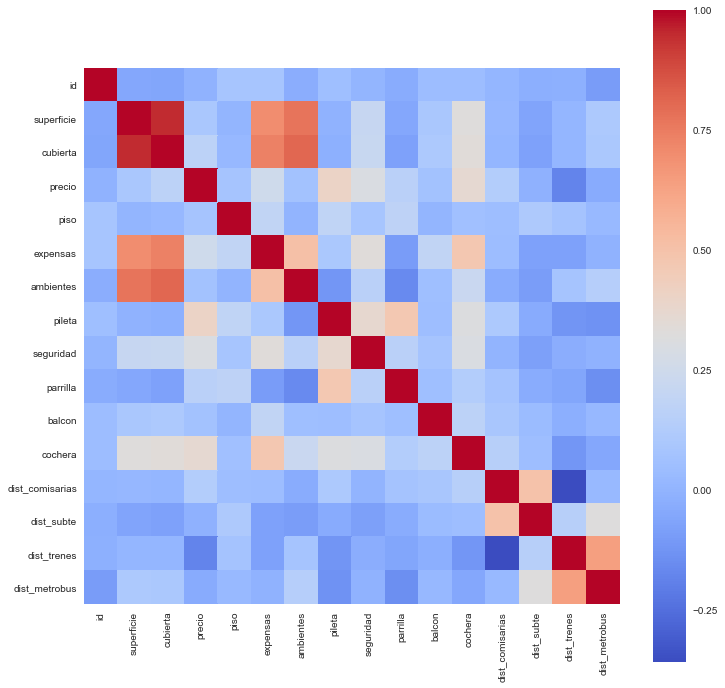

In [442]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df1.corr(), square=True, cmap='coolwarm', ax=ax);

In [443]:
df1.superficie.corr(df1.ambientes)
df.pileta.corr(df1.parrilla)
df.ambientes.corr(df.precio)

0.7765621491354135

0.4734427171097456

0.06807715443037839

Ambientes muy correlacionada con Superficie.  **corr=0.78**  
Podriamos sacar ambientes y dejar solo superficie y ganar 300 datapoints más.
Parrilla y pileta correlacionadas positivamente. **corr=0.47**

In [444]:
df1.to_csv('palermo.csv')